In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, unique
from utils import *
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
from tqdm import tqdm
from IPython.utils import io

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
hosts = Table.read('kepler_host_matches.fits').to_pandas()

/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pairs = Table(names=('kepid', 'gaia_id1', 'gaia_id2', 'gmag1', 
                    'gmag2', 'parallax1', 'parallax2', 'pmra1', 'pmra2',
                    'pmdec1', 'pmdec2', 'chisq'), 
             dtype=('int64', 'int64', 'int64', 'float64', 
                    'float64', 'float64', 'float64', 'float64', 'float64',
                    'float64', 'float64', 'float64'))
all_matches = pd.DataFrame()

In [5]:
for i,h in tqdm(hosts.iterrows()):
    coord = SkyCoord(ra=h['ra_2'], dec=h['dec_2'], unit=(u.degree, u.degree))
    radius = u.Quantity(1.0, u.arcmin)
    with io.capture_output() as captured: # suppress print
        query = Gaia.cone_search_async(coord, radius)
    matches = query.get_results().to_pandas()
    match_chisqs = matches.apply(calc_chisq_for_pair, args=(h,), axis=1).values
    for j,c in enumerate(match_chisqs):
        if (h.loc['source_id'] != matches.iloc[j].loc['source_id']) & (c != -1) & (c < 25):
            m = matches.iloc[j]
            pairs.add_row([h['kepid'], h['source_id'], m['source_id'], h['phot_g_mean_mag'], 
                          m['phot_g_mean_mag'], h['parallax'], m['parallax'], h['pmra'], m['pmra'],
                          h['pmdec'], m['pmdec'], c])
            all_matches = all_matches.append(m)
    if (i % 100) == 0:
        print("total number of matches: {0}".format(len(pairs)))

0it [00:00, ?it/s]/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'priam_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'flame_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
1it [00:02,  2.19s/it]

total number of matches: 0


101it [03:36,  2.17s/it]

total number of matches: 0


201it [07:07,  3.33s/it]

total number of matches: 3


301it [10:53,  2.74s/it]

total number of matches: 4


401it [14:33,  2.19s/it]

total number of matches: 6


501it [17:59,  1.87s/it]

total number of matches: 6


601it [21:27,  1.90s/it]

total number of matches: 8


701it [24:50,  2.15s/it]

total number of matches: 11


801it [28:12,  2.07s/it]

total number of matches: 11


901it [31:32,  1.87s/it]

total number of matches: 13


1001it [34:44,  1.97s/it]

total number of matches: 15


1101it [38:00,  1.98s/it]

total number of matches: 15


1201it [41:13,  1.86s/it]

total number of matches: 16


1301it [44:24,  1.97s/it]

total number of matches: 18


1401it [47:34,  1.78s/it]

total number of matches: 19


1464it [49:37,  1.95s/it]


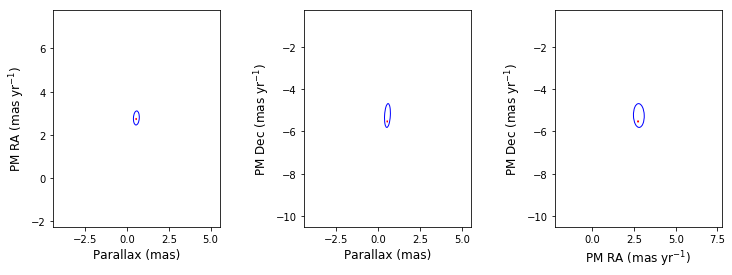

In [11]:
i = 10
p, m = pairs[i]['gaia_id1'], pairs[i]['gaia_id2']
plot_xs(hosts[hosts['source_id'] == p], all_matches[all_matches['source_id'] == m])

In [12]:
pairs

kepid,gaia_id1,gaia_id2,gmag1,gmag2,parallax1,parallax2,pmra1,pmra2,pmdec1,pmdec2,chisq
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3866536,2076169156332573568,2076169152031202304,13.114730834960938,17.98138999938965,0.9518037310256979,0.9584169353939288,3.020725935016194,3.292166297264151,-6.77467618528218,-6.999658217983766,2.492330551147461
3866536,2076169156332573568,2076169259400083072,13.114730834960938,19.29433250427246,0.9518037310256979,0.5631758151831467,3.020725935016194,3.0551422451401544,-6.77467618528218,-6.504606623059869,2.4025368690490723
4037164,2100297457959010688,2100297247503392640,15.479809761047363,20.511045455932617,3.186517815519316,1.8986361659675337,8.352578689698415,7.384050250112459,-8.64708330892036,-7.666817440825248,2.3540964126586914
4261960,2052980593536976512,2052980593531297664,15.715295791625977,20.39255714416504,1.173775896296654,2.155164145927043,4.46167004822829,3.6896497887764808,0.3349981326014147,1.0133189722275358,2.2724647521972656
5283542,2076542818486572800,2076542646682491776,15.578622817993164,19.7574520111084,1.0400049754769083,1.0118267511100159,2.849375772699628,2.323101557940078,-3.7979866640645548,-3.312347851722988,1.0791722536087036
5467126,2076743234532439552,2076743170108720640,12.347463607788086,20.096370697021484,0.47470032879115426,1.0931027172097338,2.903278914891285,4.61321072097154,-5.631684109385353,-5.76364258694053,3.178117036819458
6449358,2077707544892676736,2077613772865368960,11.573765754699707,19.651851654052734,1.1973965011976535,1.4671958700420331,2.868020028421686,2.9804420051234963,0.2986574248629279,0.863516122634721,0.985166072845459
6620003,2077107898743741312,2077107864379013888,15.650727272033691,20.979747772216797,1.9517250196433429,3.495898548352002,5.971545314096796,8.881272139262656,22.80621947449617,19.47091166472958,2.2626848220825195
6890618,2075452034239188352,2075449079297061632,14.613566398620605,19.595903396606445,0.6917382971363731,0.8854329976959255,2.9535282078284784,2.246493474577952,-0.2496444118589089,1.1450034873391017,3.7672231197357178


In [13]:
pairs.write('kepler_pairs.fits', overwrite=True)